##使用TFHub进行迁移学习

[TensorFlow Hub](http://tensorflow.org/hub)是一种共享预训练模型组件的方法。有关预先训练模型的可搜索列表，请参阅[TensorFlow模块中心](https://tfhub.dev/)。

本教程演示：

  1. 如何使用TensorFlow Hub [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)。
  2. 如何使用TensorFlow Hub进行图像分类。
  3. 如何做简单的转学习。
  
###建立
####进口

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/data")
!pwd

/content/drive/My Drive/data


需要安装的库

```
!pip install -q -U tensorflow_hub
!pip install -q tf-nightly-gpu
```



In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

In [0]:
import tensorflow_hub as hub
from tensorflow.keras import layers

##ImageNet分类器
###下载分类器
使用`hub.module`加载mobilenet，并[tf.keras.layers.Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)包裹起来作为keras层。

来自tfhub.dev的任何[TensorFlow 1.x图像分类器URL](https://tfhub.dev/s?module-type=image-classification)都可以在这里工作。

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))
])

###在单个图像上运行它
下载单个图像以试用该模型。

65536/61306 [================================] - 0s 0us/step


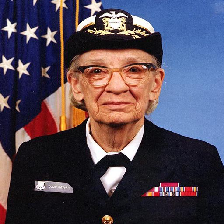

In [8]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

添加批量维度，并将图像传递给模型。

In [10]:
result =classifier.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

结果是log1的1001元素向量，对图像的每个类的概率进行评级。

因此，可以使用argmax找到顶级ID：

In [12]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

###解码预测
我们有预测的类ID，获取ImageNet标签，并解码预测

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [14]:
imagenet_labels.shape

(1001,)

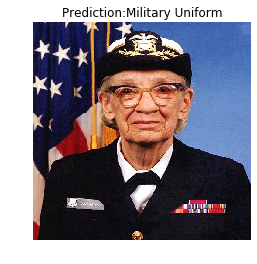

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction:"+ predicted_class_name.title())

##简单的转学习
使用TF Hub可以很容易地重新训练模型的顶层以识别数据集中的类。

###数据集
对于此示例，您将使用TensorFlow鲜花数据集：

In [16]:
data_root = tf.keras.utils.get_file('flower_photos',
                                   'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


将此数据加载到我们的模型中的最简单方法是使用[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)，

TensorFlow Hub的所有图像模块都期望浮动输入在该`[0, 1]`范围内。使用ImageDataGenerator's rescale参数来实现此目的。

图像大小将在稍后处理。

In [17]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [19]:
data_root

'/root/.keras/datasets/flower_photos'

生成的对象是返回image_batch, label_batch对的迭代器。

In [20]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


###在一批图像上运行分类器
现在在映像批处理上运行分类器。

In [21]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'sea urchin', 'volcano', 'sea urchin', 'ostrich',
       'coral fungus', 'cardoon', 'daisy', 'goblet', 'hay',
       'handkerchief', 'daisy', 'bee', 'bee', 'pot', 'spider web',
       'strawberry', 'buckeye', 'daisy', 'pot', 'stone wall',
       'stone wall', 'cardoon', 'cardoon', 'daisy', 'tricycle', 'ant',
       'daisy', 'sea urchin', 'cardoon', 'hay', 'vase'], dtype='<U30')

现在检查这些预测如何与图像对齐：

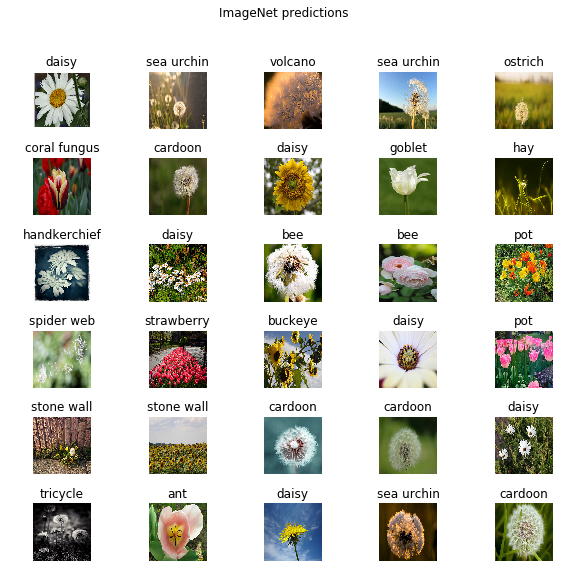

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  
_ = plt.suptitle("ImageNet predictions")

请参阅`LICENSE.txt`文件以获取图像属性。

结果远非完美，但考虑到这些不是模型训练的类（“雏菊”除外），这是合理的。

##下载无头模型
TensorFlow Hub还可以在没有顶级分类层的情况下分发模型。这些可以用来轻松做转移学习。

来自tfhub.dev的任何[TensorFlow 1.x图像特征向量URL](https://tfhub.dev/s?module-type=image-feature-vector)都可以在此处使用。

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

创建模块，并检查预期的图像大小：

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                        input_shape=(224,224,3))

特征提取器为每个图像返回1280个元素的向量

In [28]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


冻结特征提取器层中的变量，以便训练仅修改新的分类器层。

In [0]:
feature_extractor_layer.trainable = False

###附上分类头
现在将中心层包装在[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)模型中，并添加新的分类层。

In [30]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [33]:
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

###训练模型
使用compile配置培训过程：

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['acc'])

现在使用该`.fit`方法训练模型。

保持这个例子短列车只有2个时代。要显示培训进度，请使用自定义回调单独记录每个批次的丢失和准确性，而不是记录时期平均值。

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [37]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                   steps_per_epoch=steps_per_epoch,
                   callbacks=[batch_stats_callback])

Epoch 1/2


W0904 11:52:27.898363 140628088612736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 21s 187ms/step - loss: 0.7024 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 19s 167ms/step - loss: 0.3392 - acc: 0.8750


现在，即使只是几次训练迭代，我们已经可以看到模型正在完成任务。

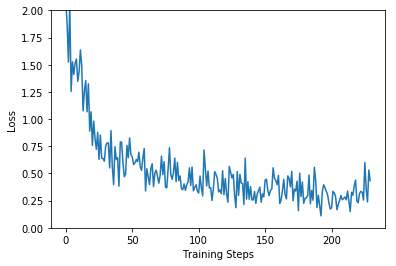

In [38]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

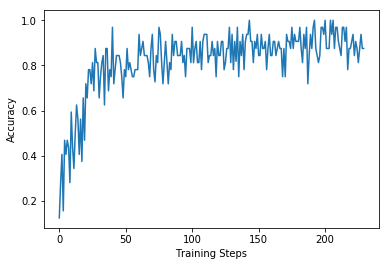

In [42]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

##检查预测
要重做之前的图，首先获取有序的类名列表：

In [44]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

通过模型运行映像批处理并将索引转换为类名。

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

绘制结果

In [0]:
label_id = np.argmax(label_batch, axis=-1)

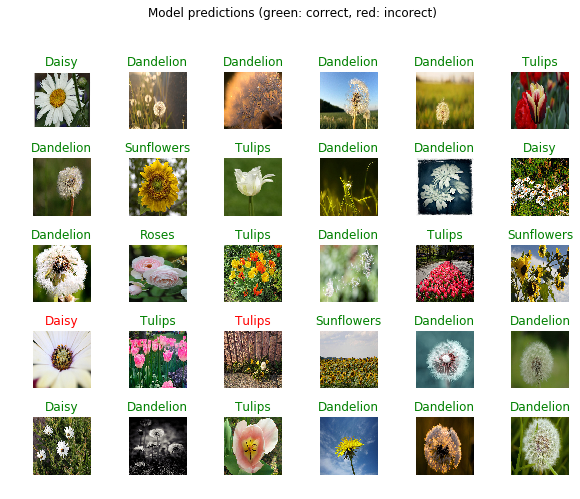

In [47]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
  
_ = plt.suptitle("Model predictions (green: correct, red: incorect)")

##导出您的模型
现在您已经训练了模型，将其导出为已保存的模型：

In [49]:
import time
t = time.time()

export_path = './models/saved_models/hub_with_keras_{}'.format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0904 12:12:48.229093 140628088612736 export_utils.py:182] Export includes no default signature!
Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7fe5c4ad5f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7fe5cdc1e0f0>,)
W0904 12:12:49.626239 140628088612736 meta_graph.py:449] Issue encountered 

'./models/saved_models/hub_with_keras_1567599160'

现在确认我们可以重新加载它，它仍然给出相同的结果：

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [52]:
abs(reloaded_result_batch - result_batch).max()

0.0

这个保存的模型可以在以后加载推理，或转换为[TFLite](https://www.tensorflow.org/lite/convert/)或[TFjs](https://github.com/tensorflow/tfjs-converter)。